In [ ]:
pip install --upgrade ultralytics

In [ ]:
# Cuts the dataset into 5 folds (images only, no labels)
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

# Parameters: adjust these paths as needed
dataset_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage"
output_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"
n_splits = 5
random_state = 42
copy_files = True  # Set to False to use symlinks instead of copying

# Gather all samples and class labels
train_dir = Path(dataset_dir) / 'train'
test_dir = Path(dataset_dir) / 'test'
samples = []  # (img_path, class_name) - Removed label_path
class_names = []
for cls_dir in sorted(train_dir.iterdir()):
    if not cls_dir.is_dir():
        continue
    cls = cls_dir.name
    class_names.append(cls)
    for img_path in (cls_dir / 'images').glob('*.*'):
        samples.append((img_path, cls))  # Removed lbl_path

# Prepare arrays for stratification
image_paths = [s[0] for s in samples]
y = [class_names.index(s[1]) for s in samples]  # Changed index to use the class_name from the simplified samples

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
summary = {}

# Create folds
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(image_paths, y), start=1):
    fold_base = Path(output_dir) / f"fold_{fold_idx}"
    summary[fold_idx] = {'train': len(train_idx), 'val': len(val_idx), 'test': 0}

    # Train/val splits
    for split, idxs in [('train', train_idx), ('val', val_idx)]:
        for cls in class_names:
            (fold_base / split / cls / 'images').mkdir(parents=True, exist_ok=True)
        for i in idxs:
            img_src, cls_name = image_paths[i], samples[i][1]  # Removed lbl_src
            img_dst = fold_base / split / cls_name / 'images' / img_src.name
            if copy_files:
                shutil.copy(img_src, img_dst)
            else:
                os.symlink(img_src.resolve(), img_dst)

    # Copy test set unchanged
    if test_dir.exists():
        dst_test = fold_base / 'test'
        if dst_test.exists():
            shutil.rmtree(dst_test)
        shutil.copytree(test_dir, dst_test)
        test_images_dir = dst_test / 'images'
        summary[fold_idx]['test'] = len(list(test_images_dir.glob('*.*')))

# Print out summary to verify
print("K-fold generation summary:")
for fold, counts in summary.items():
    print(f"Fold {fold}: train={counts['train']}, val={counts['val']}, test={counts['test']}")

In [1]:
##TRAINS THE MODEL KFOLD

import os
import gc
import torch
from ultralytics import YOLO

# ---------------- CONFIG ----------------
BASE_DIR    = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"  # root path where fold_1, …, fold_5 live
MODEL_FILE  = r"models\yolo11n-cls.pt"                         # pretrained classification model
FOLDS       = 5
EPOCHS      = 100
IMGSZ       = 640
BATCH       = 8                                        # reduced for lower VRAM usage
PATIENCE    = 5
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MEM_FRACTION = 0.6                                     # 60% GPU memory cap
# ----------------------------------------

print(f"Using device: {DEVICE}\n")

if DEVICE == "cuda":
    torch.cuda.set_per_process_memory_fraction(MEM_FRACTION, device=0)

for fold in range(1, FOLDS + 1):
    gc.collect()
    torch.cuda.empty_cache()

    fold_dir = os.path.join(BASE_DIR, f"fold_{fold}")
    if not os.path.isdir(os.path.join(fold_dir, 'train')):
        raise FileNotFoundError(f"{fold_dir}/train not found")

    print(f"\n=== Training Fold {fold}/{FOLDS} on folder {fold_dir} ===")
    model = YOLO(MODEL_FILE)
    model.train(
        data=fold_dir,
        task='classify',
        epochs=EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH,
        patience=PATIENCE,
        device=DEVICE,
        project=fold_dir,
        name='results',
        exist_ok=True,
        dropout=0.2,
        weight_decay=0.0005,
        amp=False
    )

    print(f"--- Fold {fold} complete. Best weights in {fold_dir}/results ---")


Using device: cuda


=== Training Fold 1/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=models\yolo11n-cls.pt, momentum=0.937, mosa

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train... 1202 images, 0 corrupt: 100%|██████████| 1202/1202 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 295.973.1 MB/s, size: 168.5 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\val... 301 images, 0 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100       1.6G      1.056          2        640: 100%|██████████| 151/151 [00:11<00:00, 13.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.91it/s]

                   all      0.817          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100       1.8G     0.4839          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.14it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100       1.8G     0.4158          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.34it/s]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100       1.8G     0.3604          2        640: 100%|██████████| 151/151 [00:08<00:00, 18.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.56it/s]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100       1.8G     0.3295          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.69it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100       1.8G     0.2423          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.36it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100       1.8G     0.2531          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.62it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100       1.8G      0.289          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.65it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100       1.8G     0.1764          2        640: 100%|██████████| 151/151 [00:08<00:00, 18.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.90it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100       1.8G     0.1628          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.40it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100       1.8G     0.1846          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.48it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100       1.8G      0.197          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.39it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100       1.8G     0.1935          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.50it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100       1.8G     0.1656          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.00it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100       1.8G     0.1363          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.50it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100       1.8G     0.1714          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.16it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100       1.8G     0.1517          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.53it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100       1.8G     0.1398          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.08it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100       1.8G     0.1265          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.29it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100       1.8G    0.09982          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.59it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100       1.8G     0.1084          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.46it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100       1.8G     0.0953          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.10it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100       1.8G    0.09946          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.34it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100       1.8G    0.08063          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.09it/s]

                   all       0.99          1


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

24 epochs completed in 0.064 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train... found 1202 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Ro

               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 23.67it/s]


                   all      0.997          1
Speed: 0.5ms preprocess, 1.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results
--- Fold 1 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1/results ---

=== Training Fold 2/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fl

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\train... 1202 images, 0 corrupt: 100%|██████████| 1202/1202 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1412.2876.6 MB/s, size: 203.7 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\val... 301 images, 0 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.62G      1.071          2        640: 100%|██████████| 151/151 [00:11<00:00, 12.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.35it/s]


                   all      0.864          1

      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.81G     0.4792          2        640: 100%|██████████| 151/151 [00:09<00:00, 16.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.15it/s]

                   all      0.837          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.81G     0.4376          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.44it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.81G     0.3268          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.22it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.81G     0.3501          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.63it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.81G     0.2788          2        640: 100%|██████████| 151/151 [00:08<00:00, 16.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.11it/s]


                   all      0.963          1

      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.81G     0.2942          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.21it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.81G      0.264          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.12it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.81G     0.2278          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.57it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.81G     0.1572          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.84it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.81G      0.165          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.45it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.81G     0.2063          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.91it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.81G     0.1723          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.58it/s]

                   all      0.983          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.036 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\train... found 1202 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\val... found 301 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\test... found 48 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.24it/s]


                   all      0.987          1
Speed: 0.6ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results
--- Fold 2 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2/results ---

=== Training Fold 3/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fl

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\train... 1202 images, 0 corrupt: 100%|██████████| 1202/1202 [00:01<00:00, 818.16it/s]

train: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\train.cache


val: Fast image access  (ping: 1.63.0 ms, read: 8.31.0 MB/s, size: 183.7 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\val... 301 images, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 533.80it/s]

val: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.62G      1.054          2        640: 100%|██████████| 151/151 [00:11<00:00, 13.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.72it/s]

                   all      0.834          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.82G     0.4578          2        640: 100%|██████████| 151/151 [00:08<00:00, 16.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 20.04it/s]

                   all       0.91          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.82G     0.4425          2        640: 100%|██████████| 151/151 [00:10<00:00, 14.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 20.39it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.82G     0.3654          2        640: 100%|██████████| 151/151 [00:11<00:00, 13.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.78it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.82G     0.3603          2        640: 100%|██████████| 151/151 [00:10<00:00, 14.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 19.87it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.82G     0.2847          2        640: 100%|██████████| 151/151 [00:10<00:00, 15.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.40it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.82G     0.2662          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.30it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.82G     0.2326          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.74it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.82G     0.2315          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.64it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.82G      0.197          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.62it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.82G     0.1816          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.34it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.82G     0.1895          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.58it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.82G      0.144          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.65it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.82G     0.1706          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.04it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.82G     0.1224          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.05it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.82G     0.1312          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.48it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.82G     0.1082          2        640: 100%|██████████| 151/151 [00:08<00:00, 17.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.77it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.82G     0.1311          2        640: 100%|██████████| 151/151 [00:09<00:00, 16.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.60it/s]

                   all       0.99          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



18 epochs completed in 0.051 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\train... found 1202 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\val... found 301 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\test... found 48 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.91it/s]


                   all          1          1
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results
--- Fold 3 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3/results ---

=== Training Fold 4/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fl

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\train... 1203 images, 0 corrupt: 100%|██████████| 1203/1203 [00:01<00:00, 797.53it/s]

train: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\train.cache


val: Fast image access  (ping: 0.30.2 ms, read: 10.31.6 MB/s, size: 187.5 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 518.06it/s]

val: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.61G      1.037          3        640: 100%|██████████| 151/151 [00:11<00:00, 12.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 22.68it/s]

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.81G     0.4938          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.33it/s]

                   all      0.907          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.81G     0.4197          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.39it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.81G      0.365          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.24it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.81G      0.334          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.72it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.81G      0.315          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.42it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.81G     0.2542          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.59it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.81G     0.2229          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.68it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.81G     0.2279          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.15it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.81G     0.1724          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.17it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.81G     0.1749          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.05it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.81G     0.1855          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.38it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.81G     0.1503          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.49it/s]

                   all      0.967          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.036 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\train... found 1203 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\val... found 300 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\test... found 48 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.98it/s]


                   all       0.98          1
Speed: 0.6ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results
--- Fold 4 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4/results ---

=== Training Fold 5/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fl

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\train... 1203 images, 0 corrupt: 100%|██████████| 1203/1203 [00:01<00:00, 821.17it/s]

train: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\train.cache


val: Fast image access  (ping: 0.30.1 ms, read: 10.80.8 MB/s, size: 188.5 KB)


val: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 514.55it/s]

val: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.61G      1.044          3        640: 100%|██████████| 151/151 [00:11<00:00, 13.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.41it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100       1.8G     0.5248          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.89it/s]

                   all      0.893          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100       1.8G      0.375          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.73it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100       1.8G     0.3386          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.28it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100       1.8G     0.3292          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.50it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100       1.8G     0.2938          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.99it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100       1.8G     0.2681          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.86it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100       1.8G     0.2233          3        640: 100%|██████████| 151/151 [00:08<00:00, 18.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.60it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100       1.8G     0.2457          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.02it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100       1.8G     0.1688          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.88it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100       1.8G     0.1739          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.19it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100       1.8G       0.18          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.04it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100       1.8G     0.1596          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.19it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100       1.8G     0.1702          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.32it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100       1.8G     0.1613          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.30it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100       1.8G     0.1321          3        640: 100%|██████████| 151/151 [00:08<00:00, 16.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.75it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100       1.8G     0.1549          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.92it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100       1.8G     0.1336          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.41it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100       1.8G     0.1153          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.53it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100       1.8G       0.14          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.10it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100       1.8G      0.105          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.98it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100       1.8G     0.1086          3        640: 100%|██████████| 151/151 [00:08<00:00, 17.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.86it/s]

                   all      0.983          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 17, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.059 hours.
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results\weights\last.pt, 3.2MB
Optimizer stripped from C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results\weights\best.pt, 3.2MB

Validating C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results\weights\best.pt...
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\train... found 1203 images in 5 classes  
val: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\val... found 300 images in 5 classes  
test: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\test... found 48 images in 5 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 23.00it/s]


                   all      0.997          1
Speed: 0.5ms preprocess, 1.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5\results
--- Fold 5 complete. Best weights in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_5/results ---


In [2]:
#Checks whhich fold is the best
import pandas as pd
import os
import shutil

# Set the correct base directory where the folds exist
base_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"

# Dynamically find the fold directories inside the base folder
fold_dirs = [f"fold_{i+1}" for i in range(5)]

results = []

for fold in fold_dirs:
    csv_path = os.path.join(base_dir, fold, "results", "results.csv")
    print(f"Checking: {csv_path} -> Exists: {os.path.exists(csv_path)}")  # Debug line

    if not os.path.exists(csv_path):
        print(f"❌ Missing results.csv in {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    print(f"🔍 Columns in {csv_path}:\n{df.columns.tolist()}")  # Debugging line

    # Look for the accuracy column
    accuracy_column = None
    for col in df.columns:
        if 'accuracy' in col.lower():
            accuracy_column = col
            print(f"✅ Found column: {col}")
            break

    if accuracy_column is None:
        print(f"⚠️ 'accuracy' column not found in {csv_path}")
        continue

    best_row = df.loc[df[accuracy_column].idxmax()]
    train_loss = best_row["train/loss"]
    val_loss = best_row["val/loss"]
    loss_gap = abs(train_loss - val_loss)

    results.append({
        "Fold": fold,
        "Epoch": int(best_row["epoch"]),
        "Accuracy": best_row[accuracy_column],
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Loss Gap": loss_gap,
        "Learning Rate": best_row["lr/pg0"]
    })

results_df = pd.DataFrame(results)

if not results_df.empty:
    print("\n📊 5-Fold Cross-Validation Summary:")
    print(results_df.to_string(index=False))

    # Normalize accuracy and loss gap for ranking
    results_df["Accuracy Rank"] = results_df["Accuracy"].rank(ascending=False)
    results_df["Loss Gap Rank"] = results_df["Loss Gap"].rank(ascending=True)

    # Combined score: prioritize high accuracy + low overfitting
    results_df["Overall Score"] = results_df["Accuracy Rank"] + results_df["Loss Gap Rank"]

    best_fold = results_df.loc[results_df["Overall Score"].idxmin()]
    print(f"\n🎯 Selected Best Generalizing Fold: {best_fold['Fold']} (Epoch {best_fold['Epoch']})")
    print(f"   Accuracy: {best_fold['Accuracy']:.4f}, Loss Gap: {best_fold['Loss Gap']:.4f}")

    # Adjust the model path to match the correct directory structure
    best_model_path = os.path.join(base_dir, best_fold["Fold"], "results", "weights", "best.pt")
    dest_dir = os.path.join(base_dir, "..", "final_model")
    os.makedirs(dest_dir, exist_ok=True)

    if os.path.exists(best_model_path):
        shutil.copy(best_model_path, os.path.join(dest_dir, "best_fold.pt"))
        print(f"📦 Copied best.pt to: {os.path.join(dest_dir, 'best_fold.pt')}")
    else:
        print(f"❌ Missing best.pt at: {best_model_path}")
else:
    print("\n⚠️ No valid results found. Please check the folder structure and CSV files.")

Checking: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results\results.csv -> Exists: True
🔍 Columns in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\results\results.csv:
['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
✅ Found column: metrics/accuracy_top1
Checking: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results\results.csv -> Exists: True
🔍 Columns in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_2\results\results.csv:
['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
✅ Found column: metrics/accuracy_top1
Checking: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results\results.csv -> Exists: True
🔍 Columns in C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_3\results\results.csv:
['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', '

In [3]:
# CONFUSION MATRIX

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Reload your trained classification weights
weights = "best_fold.pt"

model   = YOLO(weights)

# 2. Grab and extend the model's names dict
names = model.names.copy()
no_damage_idx = max(names.keys()) + 1
names[no_damage_idx] = "no_damage"

# 3. Validation setup
val_root = "Road_Damage/test"
folders  = [
    "potholes",
    "crack_issues",
    "alligator_crack_issues",
    "ravelling",
    "open_manhole"
]

# 4. Invert for lookup
name_to_idx = {v: k for k, v in names.items()}

# 5. Choose a confidence threshold below which we call it "no_damage"
CONF_THRESH = 0.3

y_true, y_pred = [], []

for folder in folders:
    true_idx = name_to_idx[folder]
    img_dir  = os.path.join(val_root, folder, "images")
    for fn in os.listdir(img_dir):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        path = os.path.join(img_dir, fn)
        y_true.append(true_idx)

        # Run classification
        res = model(path, imgsz=640)[0]

        # Use top1 and top1conf directly
        top_idx  = int(res.probs.top1)
        top_conf = float(res.probs.top1conf)

        # Assign no_damage if confidence is too low
        if top_conf < CONF_THRESH:
            pred_idx = no_damage_idx
        else:
            pred_idx = top_idx

        y_pred.append(pred_idx)
# 6. Print classification report (include labels for all classes)
sorted_idx = sorted(name_to_idx.values())  # e.g. [0,1,2,3,4,5,6]

print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=sorted_idx,
    target_names=[names[i] for i in sorted_idx],
    zero_division=0
))

# 7. Build & save the confusion matrix
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=sorted_idx
)
disp = ConfusionMatrixDisplay(
    cm,
    display_labels=[names[i] for i in sorted_idx]
)

fig, ax = plt.subplots(figsize=(8, 7))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Validation Confusion Matrix (incl. no_damage)")
plt.tight_layout()

out_path = "confusion_matrix_with_no_damage.png"
plt.savefig(out_path, dpi=150)
print(f"Saved confusion matrix to {out_path}")
plt.close(fig)



image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (10).jpg: 640x640 ravelling 0.85, potholes 0.14, alligator_crack_issues 0.01, open_manhole 0.00, crack_issues 0.00, 15.1ms
Speed: 33.5ms preprocess, 15.1ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (11).jpg: 640x640 potholes 1.00, ravelling 0.00, crack_issues 0.00, open_manhole 0.00, alligator_crack_issues 0.00, 15.4ms
Speed: 7.1ms preprocess, 15.4ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\test\potholes\images\4 -  Potholes (13).jpg: 640x640 potholes 0.90, crack_issues 0.10, ravelling 0.00, open_manhole 0.00, alligator_crack_issues 0.00, 14.7ms
Speed: 6.8ms preprocess, 14.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\Ro


0: 224x224 harvestman 0.59, walking_stick 0.20, chain 0.03, long-horned_beetle 0.02, pole 0.02, 40.3ms
Speed: 4.3ms preprocess, 40.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 fire_screen 0.15, doormat 0.12, handkerchief 0.08, ant 0.05, window_screen 0.05, 6.1ms
Speed: 2.7ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 doormat 0.10, pole 0.09, rule 0.08, window_screen 0.05, fire_screen 0.05, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 walking_stick 0.14, pole 0.08, crutch 0.06, bow 0.05, rule 0.04, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 walking_stick 0.69, harvestman 0.23, lacewing 0.02, cricket 0.01, long-horned_beetle 0.01, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 walking_stick 0.60, 

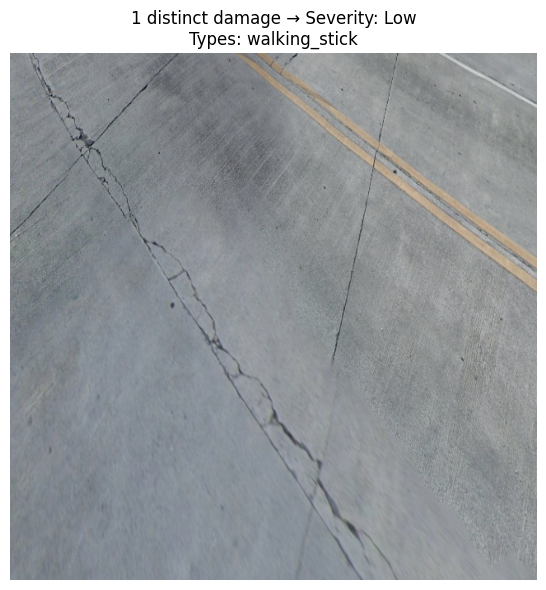

In [12]:
##Checks how many road damages are in the image using window
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. Load model
model = YOLO("models/yolo11n-cls.pt")
model.eval()

# 2. Parameters
image_path  = "Road_Damage/test/crack_issues/images/1 - Cracks (12).jpg"
patch_size  = 256
stride      = 128
conf_thresh = 0.7

# 3. Read image
img_bgr = cv2.imread(image_path)
img     = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _  = img.shape

# 4. Slide window & collect **all** positive detections
all_detections = []
for y in range(0, h - patch_size + 1, stride):
    for x in range(0, w - patch_size + 1, stride):
        patch = img[y:y+patch_size, x:x+patch_size]
        res   = model(patch, imgsz=patch_size)[0]
        conf  = float(res.probs.top1conf)
        cls   = int(res.probs.top1)
        if conf >= conf_thresh:
            label = model.names.get(cls, str(cls))
            all_detections.append({
                "label": label,
                "conf":  conf,
                "coords": (x, y)
            })


# --- DEBUG: Print Top 8 Patches by Confidence ---
all_detections.sort(key=lambda d: d["conf"], reverse=True)
top_dets = all_detections[:8]   # only top 8 patches

# --- DEBUG: Print Top 8 Patches by Confidence ---
print("=== Top 8 patch detections ===")
for i, det in enumerate(top_dets, 1):
    x, y = det["coords"]
    print(f"{i}. Class: {det['label']:<15} Confidence: {det['conf']:.3f}  at x={x}, y={y}")
print("==============================\n")


# 5. Now build the *unique* label set for severity logic
unique_labels = {d["label"] for d in top_dets}

# 7. Determine severity
n = len(unique_labels)
if   n == 0: severity = "None"
elif n == 1: severity = "Low"
elif n == 2: severity = "Moderate"
else:        severity = "High"


# 7. Print summary & list of found types
print(f"The image has {n} distinct damage{'s' if n!=1 else ''} found, this road is determined to have {severity} severity")
if n > 0:
    print("Detected damage types:", ", ".join(sorted(unique_labels)))
else:
    print("No damage types detected above threshold")

# 8. Display full image with title
title_lines = [
    f"{n} distinct damage{'s' if n!=1 else ''} → Severity: {severity}"
]
if n > 0:
    title_lines.append("Types: " + ", ".join(sorted(unique_labels)))

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title("\n".join(title_lines), fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# 1. Load TorchScript model
model = torch.jit.load("model_mobile.ptl")
model.eval()

# 2. Parameters
image_path  = "Road_Damage/test/crack_issues/images/1 - Cracks (12).jpg"
patch_size  = 256
stride      = 128
conf_thresh = 0.7

# 3. Preprocessing transform (match model input format)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((patch_size, patch_size)),
    transforms.ToTensor()
])

# 4. Read image
img_bgr = cv2.imread(image_path)
img     = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _  = img.shape

# 5. Sliding window over the image
all_detections = []
for y in range(0, h - patch_size + 1, stride):
    for x in range(0, w - patch_size + 1, stride):
        patch = img[y:y+patch_size, x:x+patch_size]
        input_tensor = transform(patch).unsqueeze(0)  # [1, 3, 256, 256]

        with torch.no_grad():
            output = model(input_tensor)

        # Unwrap model output
        if isinstance(output, (tuple, list)):
            output = output[0]

        # Expecting shape: [N, 6] — each row: [x1, y1, x2, y2, conf, cls]
        if isinstance(output, torch.Tensor) and output.ndim == 2 and output.shape[1] >= 6:
            for det in output:
                x1, y1, x2, y2, conf, cls = det[:6]
                conf = float(conf)
                cls = int(cls)
                if conf >= conf_thresh:
                    all_detections.append({
                        "label": str(cls),  # you can map this to real label names later
                        "conf": conf,
                        "coords": (x, y)
                    })

# 6. Sort and display top detections
all_detections.sort(key=lambda d: d["conf"], reverse=True)
top_dets = all_detections[:8]

print("=== Top 8 patch detections ===")
for i, det in enumerate(top_dets, 1):
    x, y = det["coords"]
    print(f"{i}. Class: {det['label']:<15} Confidence: {det['conf']:.3f}  at x={x}, y={y}")
print("==============================\n")

# 7. Severity estimation
unique_labels = {d["label"] for d in top_dets}
n = len(unique_labels)
if   n == 0: severity = "None"
elif n == 1: severity = "Low"
elif n == 2: severity = "Moderate"
else:        severity = "High"

print(f"The image has {n} distinct damage{'s' if n!=1 else ''} found, this road is determined to have {severity} severity")
if n > 0:
    print("Detected damage types:", ", ".join(sorted(unique_labels)))
else:
    print("No damage types detected above threshold")

# 8. Show result
title_lines = [
    f"{n} distinct damage{'s' if n!=1 else ''} → Severity: {severity}"
]
if n > 0:
    title_lines.append("Types: " + ", ".join(sorted(unique_labels)))

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title("\n".join(title_lines), fontsize=12)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (506722630.py, line 1)

In [8]:
from ultralytics import YOLO

# Load the model
model = YOLO('best_fold.pt')

# Run inference on the new image
image_path = r"C:\Users\jazzb\ImageDetection-Yolov11\annotated\Ravelling - Annotated\Ravelling - IMAGES\IMG_20250508_135007.jpg"
results = model(image_path)

# Show the result with bounding boxes (in a window or inline if in Jupyter)
results[0].show()


image 1/1 C:\Users\jazzb\ImageDetection-Yolov11\annotated\Ravelling - Annotated\Ravelling - IMAGES\IMG_20250508_135007.jpg: 640x640 crack_issues 0.53, alligator_crack_issues 0.26, ravelling 0.17, potholes 0.04, open_manhole 0.01, 13.5ms
Speed: 56.5ms preprocess, 13.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
